In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import netCDF4 as cdf
import h5py as hdf
from tm5tools import globarea
import numpy as np
import matplotlib.pyplot  as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from maptools import select_map
import csv
import sys
from copy import copy
import pandas as pd
import os,sys
from calendar import monthrange,isleap
from mpl_toolkits.basemap import Basemap
from __future__ import division

In [3]:
biomes_sib=['No biome specified',                     #0
            'Tall Broadleaf-Evergreen Trees',         #1
            'Tall Broadleaf-Deciduous Trees',         #2
            'Tall Broadleaf and Needleleaf Trees',    #3
            'Tall Needleleaf Trees',                  #4
            'Tall Needleleaf-DECIDUOUS Trees',        #5
            'Short Vegetation (Savanna)',             #6
            'Short Vegetation (Grasslands)',          #7 
            'Short Vegetation (None)',                #8
            'Short Broadleaf Shrubs with Bare Soil',  #9
            'Short Ground Cover (Tundra)',            #10
            'No Vegetation (Low Latitude Desert)',    #11
            'Agriculture']                            #12

clrs_sib=['lightgray',     #0
          'green',         #1
          'magenta',       #2
          'orange',        #3
          'darkgreen',     #4
          'yellow',        #5
          'tan',           #6
          'lawngreen',     #7
          'purple',        #8
          'orangered',     #9
          'brown',         #10
          'wheat',         #11
          'darkslateblue'] #12

In [3]:
mf = cdf.Dataset('/Users/botia/daily_fires/amazon_mask.nc')
print mf.file_format 
print mf.dimensions.keys()
print mf.dimensions['longitude'] 
print mf.dimensions['latitude']

# the mask has a 1x1 degree resolution
mask = mf.variables['regionmask'][:]
fac = 86400.*365.*12./1.e15
glarea = globarea(im=360,jm=180)
print glarea.sum()

NETCDF4
[u'longitude', u'latitude']
<type 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 360

<type 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 180

5.1006447191e+14


In [4]:
## Creating masks
f = cdf.Dataset('/Storage/CO2/carbontracker/input/ctdas_2012/regions_sibcasa.nc') # assigning to f the dataset from the netcdf file 
print f.dimensions.keys()
print f.dimensions['lat'] 
print f.dimensions['lon']
tc = f.variables['transcom_regions'][:]     #from f the variable transcom_regions is assigned to tc
biomes = f.variables['land_ecosystems'][:]  # This biomes, include the whole world and the ocean has nothing assigned (NaN).
f.close() 
print type(biomes), shape(biomes), type(tc)
                                            #biomes is a masked array

[u'lat', u'lon']
<type 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 180

<type 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 360

<class 'numpy.ma.core.MaskedArray'> (180, 360) <type 'numpy.ndarray'>


<class 'numpy.ma.core.MaskedArray'>


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


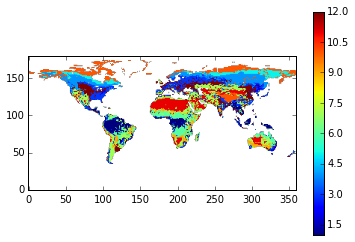

In [5]:
imshow(biomes)
colorbar()
plt.gca().invert_yaxis()
print type(biomes)

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]] [[0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 ..., 
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]] <class 'numpy.ma.core.MaskedArray'>


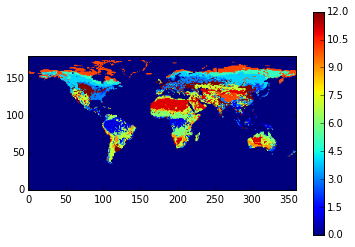

In [6]:
biomes[np.where(biomes.mask)] = 0 # Where biomes is masked (invalid), in the ocean, where the values are invalid for calculations
                                  # as it seen in the white map above, it is set to zero. In this way they become valid and 
                                  # usable. Note that the map begins from zero now
print biomes.mask, biomes, type(biomes)
imshow(biomes)
colorbar()
plt.gca().invert_yaxis()

<class 'numpy.ma.core.MaskedArray'> <class 'numpy.ma.core.MaskedArray'>


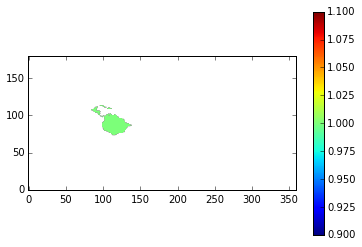

In [7]:
index = np.where(tc <> 3)           # defines an index for the places where the transcom regions are different than 3
tc[index] = 0                       # everywhere in tc where the index is present (not 3) is equal to zero
index = np.where(tc <> 0)           # a new index to redefine tc
tc[index] = 1                       # everywhere in tc where the index is present, 3, is equal to 1
tc = np.ma.masked_where(tc == 0,tc) # masks array where a condition is met, it changes the type of tc to masked array, it was a numpy array
                                    # the condition is that where tc is zero (oceans), it is masked
                                    # numpy.ma.masked_where(condition, a, copy=True)
imshow(tc)
colorbar()
plt.gca().invert_yaxis()
print type (tc),type(biomes)
#OUTPUT: constrained transcom region in southamerica

<class 'numpy.ma.core.MaskedArray'> (180, 360)


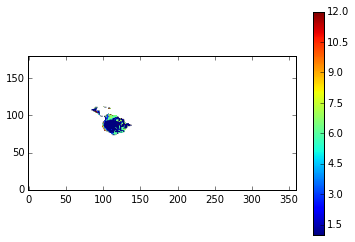

In [8]:
biomes = np.ma.masked_where(tc == 0,biomes) # same as above
biomes = np.ma.masked_where(biomes == 0,biomes)
# Biomes = 0 is the ocean, and tc = 0 is the land, except for SAM, so this places are masked.
imshow(biomes)
colorbar()
plt.gca().invert_yaxis()
print type(biomes), shape(biomes)
#OUTPUT: Biome map for southamerica 

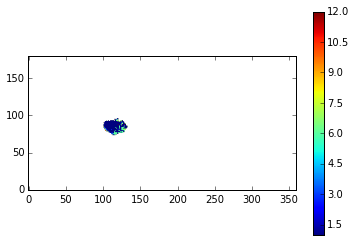

In [9]:
### Constrained biome map for Amazonia
biomes = np.ma.masked_where(mask == 0,biomes) 
imshow(biomes)
colorbar()
plt.gca().invert_yaxis()

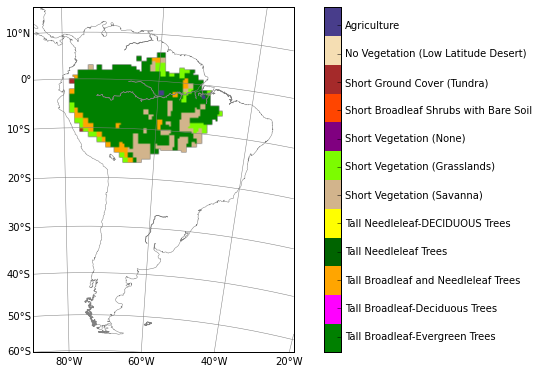

In [11]:
lons=np.arange(-179.5,180,1)
lats=np.arange(-89.5,90,1)

clrs = clrs_sib[1:]
plotmap = biomes
maxnr = len(biomes_sib)
labels = biomes_sib[1:]
savename = 'SiBCASA_biome_amazon_map.png'

fig=plt.figure(figsize=(12,6))

ax=fig.add_axes([0.05,0.1,0.7,0.8])
#m,nx,ny=select_map('Global Cylinder')

m,nx,ny=select_map('South America Albers')
fluxmap = m.transform_scalar((plotmap),lons,lats,nx,ny,order=0)
m.drawcoastlines(color='grey',linewidth=0.5)
#m.drawparallels(np.arange(-90,91,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0])
#m.drawmeridians(np.arange(-180,181,60),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1])
m.drawparallels(np.arange(-60,30,10),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0])
m.drawmeridians(np.arange(-120,0,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1])
cmap = mpl.colors.ListedColormap(clrs)
im=m.imshow(fluxmap,cmap=cmap)
#bounds=np.arange(-0.5,maxnr+0.5,1)
ticks=np.arange(1.5,15.5,0.9)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="4%", pad=0.2)
#cbar=plt.colorbar(im,boundaries=bounds,ticks=ticks,cax=cax)
cbar=plt.colorbar(im,ticks=ticks)
cbar.ax.set_yticklabels(labels,va='center',fontsize=10)
#fig.savefig(savename)
plt.show()
# this map is wrong

In [24]:
######################################## AREA analysis for the biome map #############################################
# This are basically the areas assigned to each biome in SiBCASA
# REVISAR ESTO Y LO QUE SIGUE-TOCA MODIFICARLO PARA QUE CUADRE CON SIBCASA SIN KOPPEN
biome_names_list = []
area_list = []
for b in range(0,13):
    biome_names_list.append(biomes_sib[b])
    maskb = np.zeros((180,360))+1
    maskb = np.ma.masked_where(biomes*mask!=b,maskb)
    area = ((maskb*glarea).sum())/1e6
    area_list.append('%.2f'%(area))
    data_series_area = {'Area km2':area_list}
    df_areas = pd.DataFrame(data_series_area,index=biome_names_list)

    print biomes_sib[b],((maskb*glarea).sum())/1e6,'km2'

print area #df_areas

#df_areas = df_areas.drop(df_areas.index[0])
df_areas

No biome specified -- km2
Tall Broadleaf-Evergreen Trees 4556550.3141 km2
Tall Broadleaf-Deciduous Trees -- km2
Tall Broadleaf and Needleleaf Trees 316554.028936 km2
Tall Needleleaf Trees -- km2
Tall Needleleaf-DECIDUOUS Trees -- km2
Short Vegetation (Savanna) 740619.147974 km2
Short Vegetation (Grasslands) 379667.323344 km2
Short Vegetation (None) -- km2
Short Broadleaf Shrubs with Bare Soil -- km2
Short Ground Cover (Tundra) 24520.799855 km2
No Vegetation (Low Latitude Desert) -- km2
Agriculture 24704.7736874 km2
24704.7736874


,Area km2
No biome specified,nan
Tall Broadleaf-Evergreen Trees,4556550.31
Tall Broadleaf-Deciduous Trees,nan
Tall Broadleaf and Needleleaf Trees,316554.03
Tall Needleleaf Trees,nan
Tall Needleleaf-DECIDUOUS Trees,nan
Short Vegetation (Savanna),740619.15
Short Vegetation (Grasslands),379667.32
Short Vegetation (None),nan
Short Broadleaf Shrubs with Bare Soil,nan


[75.40691024307587, 5.2386914888017433, 12.25659719937409, 6.2831610700396636, 0.40579772830126282, 0.40884227040737608] 100.0


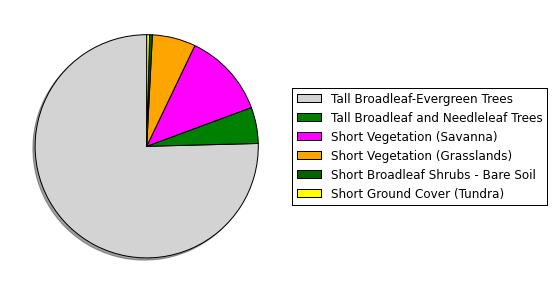

In [48]:
df_areas = df_areas.astype(float)
areas = df_areas['Area km2'].values
total_area = df_areas.sum()
pie_list = []
legenda=['Tall Broadleaf-Evergreen Trees',
         'Tall Broadleaf and Needleleaf Trees',                         #6
         'Short Vegetation (Savanna)',                                  #9
         'Short Vegetation (Grasslands)',                               #10
         'Short Broadleaf Shrubs - Bare Soil',                          #12
         'Short Ground Cover (Tundra)',                                 #13
         'Agriculture']                                                 #15

#biomes_sib
fig = plt.figure(1,figsize=(5,5))
for i in areas:
    pie_list.append((i/total_area[0])*100)
pie_list = [x for x in pie_list if str(x) != 'nan']
print pie_list, sum(pie_list)

plt.pie(pie_list,colors=clrs_sib,startangle=90,shadow=True)
plt.legend(legenda,loc='center left',bbox_to_anchor=(1, 0.5)) 
fig.savefig('BiomePercentageAreaSiBCASA.png')

In [50]:
total_area = df_areas.sum()
total_area

Area km2    6042616.38
dtype: float64

# CHECKING AREAS OTHER METHOD
- This is the correct one. The one above was not including Shrubs, biome number 10

<class 'numpy.ma.core.MaskedArray'>


'\nnumbers = []\nfor i in range(180):\n    for j in range(360):\n        numbers.append((biomes_sibcasa*mask)[i][j])\nprint type(biomes_sibcasa)#set(numbers)'

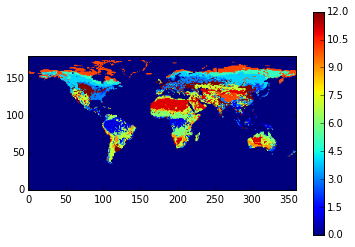

In [11]:
f              = cdf.Dataset('/Storage/CO2/carbontracker/input/ctdas_2012/regions_sibcasa.nc') 
biomes_sibcasa = f.variables['land_ecosystems'][:]  
biomes_sibcasa[np.where(biomes_sibcasa.mask)] = 0
print type(biomes_sibcasa)
imshow(biomes_sibcasa)
colorbar()
plt.gca().invert_yaxis()
'''
numbers = []
for i in range(180):
    for j in range(360):
        numbers.append((biomes_sibcasa*mask)[i][j])
print type(biomes_sibcasa)#set(numbers)'''

In [12]:
print type(biomes_sibcasa)

<class 'numpy.ma.core.MaskedArray'>


In [86]:
sava    = np.zeros((180,360),float) 
ebf     = np.zeros((180,360),float) 
gras    = np.zeros((180,360),float) 
mix     = np.zeros((180,360),float) # 3
tun     = np.zeros((180,360),float)
agr     = np.zeros((180,360),float)
shr     = np.zeros((180,360),float) # 9

for i in range(180):
    for j in range(360):
        bio = int((biomes_sibcasa*mask)[i,j])

        if bio == 1:
            ebf[i][j] = 1
        if bio == 3:
            mix[i][j] = 1
        if bio == 6:
            sava[i][j] = 1
        if bio == 7:
            gras[i][j] = 1 
        if bio == 9:
            shr[i][j] = 1
        if bio == 10:
            tun[i][j] = 1
        if bio == 12:
            agr[i][j] = 1

area_sava = (sava*glarea).sum()/1e6
area_ebf  = (ebf*glarea).sum()/1e6
area_gras = (gras*glarea).sum()/1e6
area_mix  = (mix*glarea).sum()/1e6
area_tun  = (tun*glarea).sum()/1e6
area_agr  = (agr*glarea).sum()/1e6
area_shr  = (shr*glarea).sum()/1e6

total_area_amazon = area_agr + area_tun + area_mix + area_gras + area_ebf + area_sava + area_shr

print 'total', total_area_amazon/1000000, '1e6 km2'
print 'ebf', area_ebf/1000000, 'km2', area_ebf/total_area_amazon*100
print 'mix', area_mix/1000000, 'km2', area_mix/total_area_amazon*100
print 'sava', area_sava/1000000, 'km2', area_sava/total_area_amazon*100
print 'gras', area_gras/1000000, 'km2', area_gras/total_area_amazon*100
print 'shrubs', area_shr/1000000, 'km2', area_shr/total_area_amazon*100
print 'tun', area_tun/1000000, 'km2', area_tun/total_area_amazon*100
print 'agr', area_agr/1000000, 'km2', area_agr/total_area_amazon*100




total 7.04814294251 1e6 km2
ebf 4.71427303498 km2 66.8867398608
mix 0.340000898228 km2 4.82397847208
sava 0.979284104752 km2 13.8942145859
gras 0.84724565682 km2 12.0208353283
shrubs 0.0704144346487 km2 0.999049469101
tun 0.0365433320536 km2 0.518481710029
agr 0.0603814810307 km2 0.8567005738


1.0


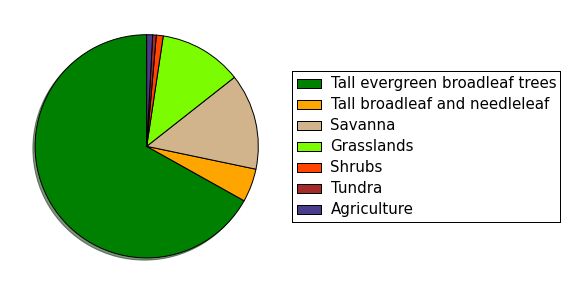

In [81]:
clrs_sib=['green',         #1
          'orange',        #3
          'tan',           #6
          'lawngreen',     #7
          'orangered',     #9
          'brown',         #10
          'darkslateblue'] #12

legenda = ['Tall evergreen broadleaf trees','Tall broadleaf and needleleaf', 'Savanna','Grasslands', 'Shrubs','Tundra','Agriculture']

#set([0.0, 1.0, 3.0, 6.0, 7.0, 9.0, 10.0, 12.0])
fig = plt.figure(1,figsize=(5,5))
pie_list = [0.668867398608,0.0482397847208,0.138942145859,0.120208353283,0.00999049469101,0.00518481710029,0.008567005738]
plt.pie(pie_list,colors=clrs_sib,startangle=90,shadow=True)
plt.legend(legenda,loc='center left',bbox_to_anchor=(1, 0.5)) 
leg = plt.gca().get_legend()
ltext  = leg.get_texts()
plt.setp(ltext, fontsize='15')  
fig.savefig('casa_areas.png',DPI=1000)
print sum(pie_list)

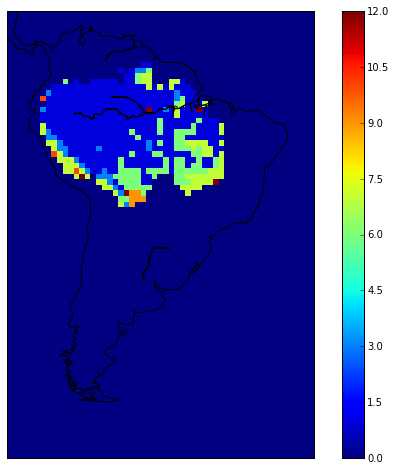

7040000.0


In [82]:
xx, yy = np.meshgrid(np.arange(-180,180,1), np.arange(-90,90,1))
plt.figure(figsize=(10,8))
m = Basemap(projection='cyl', llcrnrlat=-65, urcrnrlat=15, llcrnrlon=-85, urcrnrlon=-30)
m.drawcoastlines()
cax = m.pcolormesh(xx,yy,biomes_sibcasa*mask)
colorbar()
plt.show()


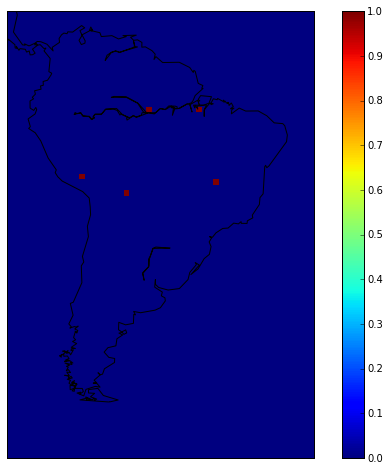

In [21]:
xx, yy = np.meshgrid(np.arange(-180,180,1), np.arange(-90,90,1))
plt.figure(figsize=(10,8))
m = Basemap(projection='cyl', llcrnrlat=-65, urcrnrlat=15, llcrnrlon=-85, urcrnrlon=-30)
m.drawcoastlines()
cax = m.pcolormesh(xx,yy,agr) #ebf, mix, sava, gras, shr, tun, agr
colorbar()
plt.show()

<class 'numpy.ma.core.MaskedArray'>


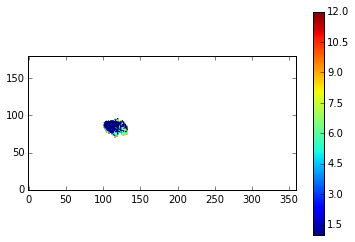

In [26]:
biomes_sibcasa_mapa = np.ma.masked_where(mask == 0,biomes_sibcasa) 
imshow(biomes_sibcasa_mapa)
colorbar()
plt.gca().invert_yaxis()
print type(biomes_sibcasa_mapa)

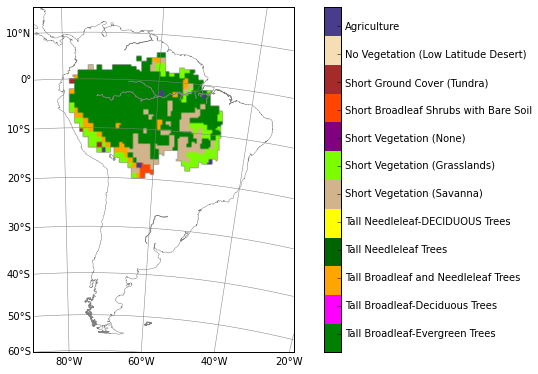

In [27]:
#set([0.0, 1.0, 3.0, 6.0, 7.0, 9.0, 10.0, 12.0])
lons=np.arange(-179.5,180,1)
lats=np.arange(-89.5,90,1)

clrs = clrs_sib[1:]

plotmap = biomes_sibcasa_mapa
maxnr = len(biomes_sib)
labels = biomes_sib[1:]
savename = 'SiBCASA_biome_amazon_map.png'

fig=plt.figure(figsize=(12,6))
ax=fig.add_axes([0.05,0.1,0.7,0.8])

#m,nx,ny=select_map('Global Cylinder')

m,nx,ny=select_map('South America Albers')
fluxmap = m.transform_scalar((plotmap),lons,lats,nx,ny,order=0)
m.drawcoastlines(color='grey',linewidth=0.5)
#m.drawparallels(np.arange(-90,91,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0])
#m.drawmeridians(np.arange(-180,181,60),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1])
m.drawparallels(np.arange(-60,30,10),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0])
m.drawmeridians(np.arange(-120,0,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1])
cmap = mpl.colors.ListedColormap(clrs)
im=m.imshow(fluxmap,cmap=cmap)
ticks=np.arange(0.7,15.5,0.89)

cbar=plt.colorbar(im,ticks=ticks)
cbar.ax.set_yticklabels(labels,va='center',fontsize=10)
fig.savefig(savename,DPI=1000)
plt.show()

# Burned Area Analysis

In [13]:
glarea = globarea(im=360,jm=180)
def sib_to_1x1(sib):
    sib1x1 = np.zeros((180,360),float)
    filename = '%s/%s/hsib_%4d%02d.qp2.nc'%('/Users/botia/sibcasa_layers','00-Sib',2010,1)
    d = cdf.Dataset(filename)
    latindex = d.variables['latindex'][:]
    lonindex = d.variables['lonindex'][:]
    for i in range(14538):
        lat=latindex[i]
        lon=lonindex[i]
        sib1x1[lat-1,lon-1]=sib[i]
    return sib1x1

In [14]:
def make_map(fill_color = True):
    m,nx,ny = select_map('South America Albers')
    m.drawcoastlines(color='grey',linewidth=0.5)
    m.drawcountries(color='grey',linewidth=0.5) 
    if fill_color:
        m.drawmapboundary(fill_color='#d8d8d8')
        m.drawparallels(np.arange(-90,91,10),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,0],fontsize=13)
        m.drawmeridians(np.arange(-180,180,15),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,0],fontsize=13)
    return m,nx,ny

/Users/botia/mnt/promise/CO2/ingrid/SiBCASA/input/gfed4_ba/monthly/
2010
2011
2012
2013
2014
2015


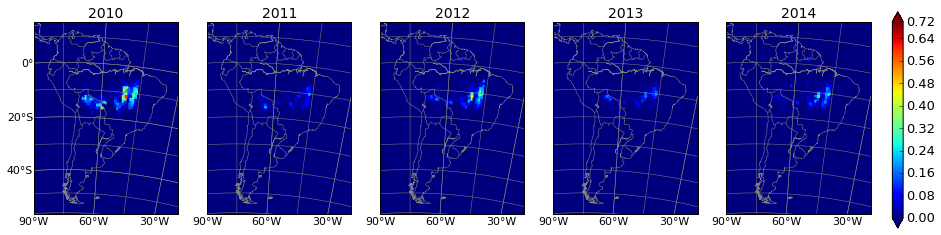

In [15]:
directory = ['/Users/botia/mnt/promise/CO2/ingrid/SiBCASA/input/gfed4_ba/monthly/']
lons=np.arange(-179.5,180,1)
lats=np.arange(-89.5,90,1)

minyear = 2010
maxyear = 2016

fig = plt.figure(1,figsize=(15,10))

for ii,dirbf in enumerate(directory):
    alltimes = []
    allba    = []
    print dirbf
    for y in range(minyear,maxyear):
        print y
        for fname in os.listdir(dirbf):
            #print fname[11:15]
            if not int(fname[11:15]) == y: continue
            bf = cdf.Dataset(dirbf+fname)
            burned_area = np.float32(bf.variables['ba'][:])
            burned_area_1x1 = sib_to_1x1(burned_area)
            
            if int(fname[15:17]) == 1:
                burned_area_year = burned_area_1x1
                #print burned_area_year[100][200]
            else:
                burned_area_year = burned_area_year + burned_area_1x1  
                #print burned_area_year[100][200], burned_area_1x1[100][200]
        
        if y == 2010:
            ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=1)
            ax1.set_title('%i'%(y),fontsize=14)
            m,nx,ny = make_map()
            m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
            m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
            fluxmap = m.transform_scalar((burned_area_year*mask),lons,lats,nx,ny,order=0)
            q=m.imshow(fluxmap,vmin=0,vmax=0.7)
            ba2010 = burned_area_year
        if y == 2011:
            ax1 = plt.subplot2grid((1, 5), (0, 1), colspan=1)
            ax1.set_title('%i'%(y),fontsize=14)
            m,nx,ny = make_map()
            #m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
            m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
            fluxmap = m.transform_scalar((burned_area_year*mask),lons,lats,nx,ny,order=0)
            q=m.imshow(fluxmap,vmin=0,vmax=0.7)
            ba2011 = burned_area_year
        if y == 2012:
            ax1 = plt.subplot2grid((1, 5), (0, 2), colspan=1)
            ax1.set_title('%i'%(y),fontsize=14)
            m,nx,ny = make_map()
            #m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
            m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
            fluxmap = m.transform_scalar((burned_area_year*mask),lons,lats,nx,ny,order=0)
            q=m.imshow(fluxmap,vmin=0,vmax=0.7)
            ba2012 = burned_area_year
        if y == 2013:
            ax1 = plt.subplot2grid((1, 5), (0, 3), colspan=1)
            ax1.set_title('%i'%(y),fontsize=14)
            m,nx,ny = make_map()
            #m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
            m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
            fluxmap = m.transform_scalar(((burned_area_year)*mask),lons,lats,nx,ny,order=0)
            q=m.imshow(fluxmap,vmin=0,vmax=0.7)
            ba2013 = burned_area_year
        if y == 2014:
            ax1 = plt.subplot2grid((1, 5), (0, 4), colspan=1)
            ax1.set_title('%i'%(y),fontsize=14)
            m,nx,ny = make_map()
            #m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
            m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
            fluxmap = m.transform_scalar((burned_area_year*mask),lons,lats,nx,ny,order=0)
            q=m.imshow(fluxmap,vmin=0,vmax=0.7)
            ba2014 = burned_area_year
        
#plt.figtext(0.4,0.32,'Fraction of burned area per grid box',fontsize=20)
#fig.subplots_adjust(right=0.85,top=0.9,wspace=-0.2,hspace=0.045)
cbar_ax = fig.add_axes([0.92, 0.36, 0.01, 0.3]) # left, bottom, width, height
cbar = fig.colorbar(q,cax=cbar_ax,extend='both')

#cbar = fig.colorbar(q, extend='max',orientation='horizontal')
cbar.ax.tick_params(labelsize=13)
#cbar.set_label('Fraction of burned area per grid box', fontsize = 16)

#fig.savefig('BurnedArea_2010-2014.png',bbox_inches='tight',DPI=1000) # I can add DPI to get higher resolution
plt.show()
plt.close()  

In [19]:
avg_ba = (ba2010 + ba2011 + ba2012 + ba2013 + ba2014)/5
avgg = (avg_ba*glarea*mask).sum()/1e6
print avgg

106748.763299


<class 'numpy.ma.core.MaskedArray'>


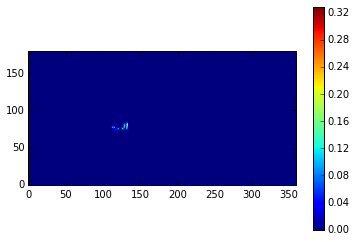

In [16]:
#biomes_amazon_casa_1x1[np.where(biomes_amazon_casa_1x1.mask)] = 0
imshow(avg_ba*mask)
colorbar()
plt.gca().invert_yaxis()
print type(biomes_sibcasa)

In [22]:
sava       = np.zeros((180,360),float) 
ebf        = np.zeros((180,360),float) 
gras       = np.zeros((180,360),float) 
mix        = np.zeros((180,360),float) # 3
tun        = np.zeros((180,360),float)
agr        = np.zeros((180,360),float)
shr        = np.zeros((180,360),float) # 9

ba_sava    = np.zeros((180,360),float) 
ba_ebf     = np.zeros((180,360),float) 
ba_gras    = np.zeros((180,360),float) 
ba_mix     = np.zeros((180,360),float) # 3
ba_tun     = np.zeros((180,360),float)
ba_agr     = np.zeros((180,360),float)
ba_shr     = np.zeros((180,360),float) # 9

year = ba2014

for i in range(180):
    for j in range(360):
        bio = int((biomes_sibcasa*mask)[i,j])

        if bio == 1:
            ebf[i][j] = 1
            ba_ebf[i,j] = year[i,j] 
        if bio == 3:
            mix[i][j] = 1
            ba_mix[i,j] = year[i,j]
        if bio == 6:
            sava[i][j] = 1
            ba_sava[i,j] = year[i,j]
        if bio == 7:
            gras[i][j] = 1 
            ba_gras[i,j] = year[i,j]
        if bio == 9:
            shr[i][j] = 1
            ba_shr[i,j] = year[i,j]
        if bio == 10:
            tun[i][j] = 1
            ba_tun[i,j] = year[i,j]
        if bio == 12:
            agr[i][j] = 1
            ba_agr[i,j] = year[i,j]

ba_area_sava = (ba_sava*glarea).sum()/1e6
ba_area_ebf  = (ba_ebf*glarea).sum()/1e6
ba_area_gras = (ba_gras*glarea).sum()/1e6
ba_area_mix  = (ba_mix*glarea).sum()/1e6
ba_area_tun  = (ba_tun*glarea).sum()/1e6
ba_area_agr  = (ba_agr*glarea).sum()/1e6
ba_area_shr  = (ba_shr*glarea).sum()/1e6

print 'ebf = ', ba_area_ebf, (ba_area_ebf/((year*glarea*mask).sum()/1e6))*100
print ba_area_mix, (ba_area_mix/((year*glarea*mask).sum()/1e6))*100
print 'sav = ', ba_area_sava, (ba_area_sava/((year*glarea*mask).sum()/1e6))*100
print 'gras = ', ba_area_gras, (ba_area_gras/((year*glarea*mask).sum()/1e6))*100
print ba_area_shr, (ba_area_shr/((year*glarea*mask).sum()/1e6))*100
print ba_area_tun, (ba_area_tun/((year*glarea*mask).sum()/1e6))*100
print ba_area_agr, (ba_area_agr/((year*glarea*mask).sum()/1e6))*100

print (ba_area_ebf + ba_area_mix + ba_area_sava +  ba_area_gras + ba_area_shr + ba_area_tun + ba_area_agr)

ebf =  28384.6996293 32.9185068759
725.60929101 0.841508796896
sav =  30408.8974634 35.2660240662
gras =  25117.2060176 29.1291058137
275.881400514 0.319947151048
34.9407998171 0.0405217942783
1279.94373398 1.48438550198
86227.1783357


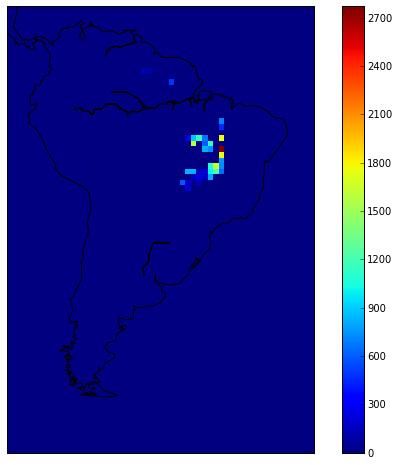

In [19]:
xx, yy = np.meshgrid(np.arange(-180,180,1), np.arange(-90,90,1))
plt.figure(figsize=(10,8))
m = Basemap(projection='cyl', llcrnrlat=-65, urcrnrlat=15, llcrnrlon=-85, urcrnrlon=-30)
m.drawcoastlines()

cax = m.pcolormesh(xx,yy,(ba_gras*glarea*mask)/1e6)
colorbar()
plt.show()

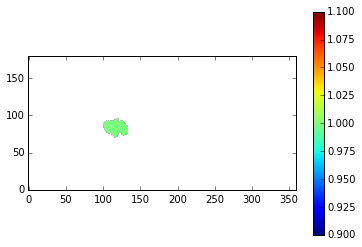

In [20]:
mf = cdf.Dataset('/Users/botia/daily_fires/amazon_mask.nc')
# the mask has a 1x1 degree resolution
mask = mf.variables['regionmask'][:]
mask = np.ma.masked_where(mask==0,mask)
glarea = globarea(im=360,jm=180)
imshow(mask)
colorbar()
plt.gca().invert_yaxis()

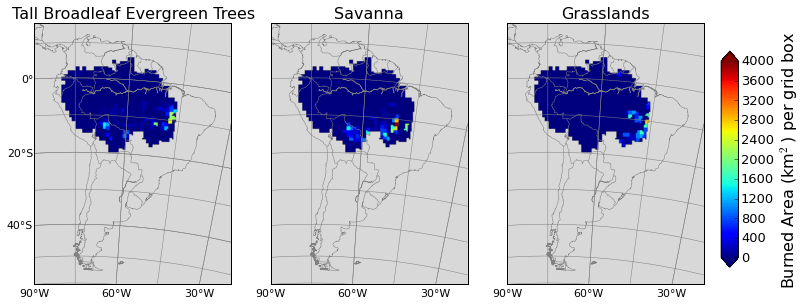

In [21]:
fig = plt.figure(1,figsize=(12,6))

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1)
ax1.set_title('Tall Broadleaf Evergreen Trees',fontsize=16)
m,nx,ny = make_map()
m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
fluxmap = m.transform_scalar(((ba_ebf*glarea*mask)/1e6),lons,lats,nx,ny,order=0)
q=m.imshow(fluxmap,vmin=0,vmax=4000)

ax1 = plt.subplot2grid((1, 3), (0, 1), colspan=1)
ax1.set_title('Savanna',fontsize=16)
m,nx,ny = make_map()
#m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
fluxmap = m.transform_scalar(((ba_sava*glarea*mask)/1e6),lons,lats,nx,ny,order=0)
q=m.imshow(fluxmap,vmin=0,vmax=4000)

ax1 = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax1.set_title('Grasslands',fontsize=16)
m,nx,ny = make_map()
#m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
fluxmap = m.transform_scalar(((ba_gras*glarea*mask)/1e6),lons,lats,nx,ny,order=0)
q=m.imshow(fluxmap,vmin=0,vmax=4000)
        
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5]) # left, bottom, width, height
cbar = fig.colorbar(q,cax=cbar_ax,extend='both')

cbar.ax.tick_params(labelsize=13)
cbar.set_label('Burned Area (km$^2$) per grid box', fontsize = 16)
fig.savefig('SiBCASABurnedArea_Ebf_Sav_Gras_2010-2014.png',bbox_inches='tight',DPI=1000) 